# **Multi‐Model NLI Exploration**

Using the dataset at https://www.kaggle.com/c/contradictory-my-dear-watson/data, building a classification model to predict whether two sentences are in:

1. Entailment

2. Neutral

3. Contradiction

Steps:

Pre-processing the data

Performing exploratory data analysis

Using BERT to build the model

Using GPT to build the model

# **Pre-process and label-flip check**

In [ ]:

import pandas as pd
from sklearn.model_selection import train_test_split
import textwrap

#  Load raw CSVs
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")
print(f"🗂️  Loaded → train: {train.shape}, test: {test.shape}\n")

#  Dropping any rows missing premise, hypothesis, or label
train = train.dropna(subset=["premise","hypothesis","label"])
train["label"] = train["label"].astype(int)
print(f"✂️  After dropna → train: {train.shape}\n")

# Show raw numeric distribution
print("📊 Raw numeric label proportions:")
print(train["label"].value_counts(normalize=True).sort_index().to_frame("proportion"), "\n")

# Showing two examples per label
print("🔍  Two random examples for each numeric label:\n")
wrap = lambda s: "\n    ".join(textwrap.wrap(s, 70))
for lbl in [0,1,2]:
    sample = train.query("label == @lbl").sample(2, random_state=lbl)
    print(f"### numeric {lbl}\n")
    for _, row in sample.iterrows():
        print("Premise   :", wrap(row.premise))
        print("Hypothesis:", wrap(row.hypothesis), "\n")

#  Flipping numeric codes because  numeric 0 looked like entailment and 2 looked like contradiction, do:
flip = {0:2, 1:1, 2:0}
train["label"] = train["label"].map(flip)



#  Stratified 90% / 10% split
train_df, val_df = train_test_split(
    train, test_size=0.10, stratify=train["label"], random_state=42
)
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
print(f"\n✂️  Split sizes → train_df: {train_df.shape}, val_df: {val_df.shape}")


🗂️  Loaded → train: (12120, 6), test: (5195, 5)

✂️  After dropna → train: (12120, 6)

📊 Raw numeric label proportions:
       proportion
label            
0        0.344554
1        0.320132
2        0.335314 

🔍  Two random examples for each numeric label:

### numeric 0

Premise   : She did not reply.
Hypothesis: She was silent. 

Premise   : ان گھروں کو پیدا کرنے کی لاگت اس سے کہیں زیادہ ہے کہ ہمارے خریداروں کے
    سینٹی میٹر ادا کیا جاسکے، لہذا ہم ان کو سستی رکھنے اور انفرادی عطیات
    پر بھروسہ کرتے ہیں.
Hypothesis: گھروں کو مطلوبہ وسائل کی ضرورت ہے. 

### numeric 1

Premise   : من ناحية أخرى ، حصل على مارك توين بينه وبين ضوء النهار.
Hypothesis: لم ير ضوء النهار منذ سنوات. 

Premise   : Kentucky officials say there is a virtual epidemic of abusive
    relationships in the state.
Hypothesis: Kentucky has the highest rate of domestic abuse. 

### numeric 2

Premise   : Prudence, unsere Beraterkolumnistin, hat sich zurückgezogen, und ihre
    Kolumne wurde von ihrer Nichte, auch Pru

# **Data Exploration**

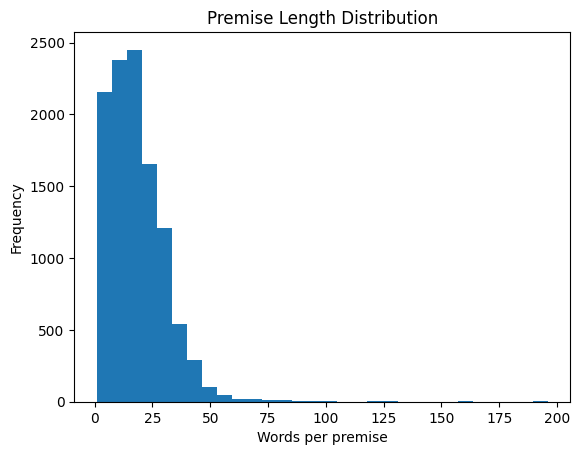

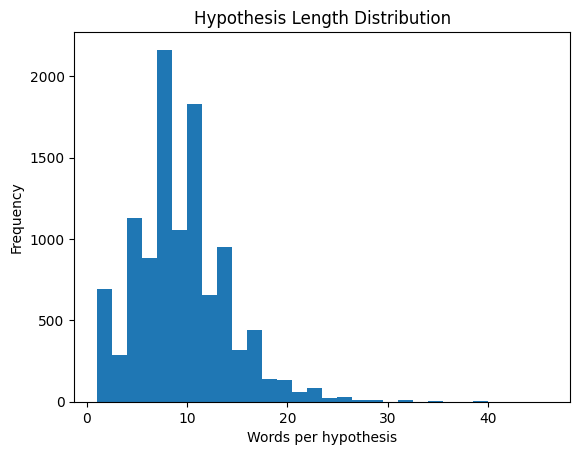

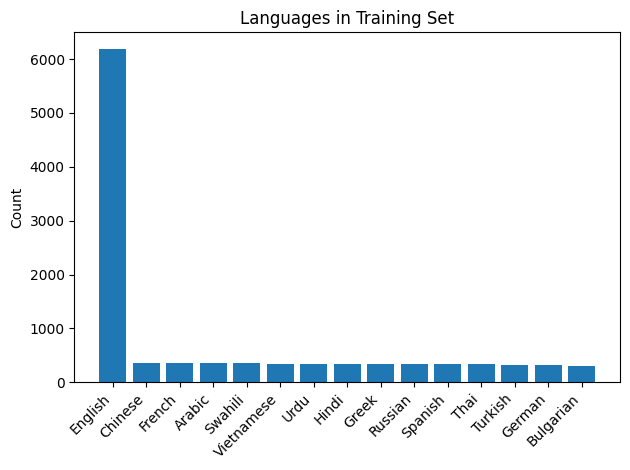

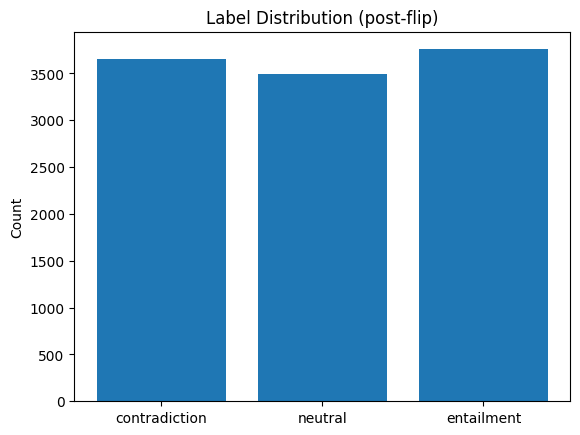

In [ ]:
import matplotlib.pyplot as plt

# Premise / Hypothesis length distributions
prem_lengths = train_df['premise'].str.split().map(len)
hyp_lengths  = train_df['hypothesis'].str.split().map(len)

plt.figure()
plt.hist(prem_lengths, bins=30)
plt.title("Premise Length Distribution")
plt.xlabel("Words per premise")
plt.ylabel("Frequency")
plt.show()

plt.figure()
plt.hist(hyp_lengths, bins=30)
plt.title("Hypothesis Length Distribution")
plt.xlabel("Words per hypothesis")
plt.ylabel("Frequency")
plt.show()

#  Language distribution
lang_counts = train_df['language'].value_counts()
plt.figure()
plt.bar(lang_counts.index, lang_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title("Languages in Training Set")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Label distribution
# After flipping, train_df['label'] should now be: 0=contradiction,1=neutral,2=entailment
label_counts = train_df['label'].value_counts().sort_index()
plt.figure()
plt.bar(["contradiction","neutral","entailment"], label_counts.values)
plt.title("Label Distribution (post‐flip)")
plt.ylabel("Count")
plt.show()


In [ ]:
!pip -q install -U transformers datasets evaluate accelerate scikit-learn matplotlib

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from evaluate import load
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


# **Fine‐tuning BERT‐base‐multilingual‐cased with EarlyStopping**

Map:   0%|          | 0/10908 [00:00<?, ? examples/s]

Map:   0%|          | 0/1212 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:  46%|####5     | 325M/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Fine‐tuning BERT (up to 10 epochs with early stop)…


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.964400,0.900943,0.591584,0.589333
2,0.768000,0.813413,0.646865,0.646634
3,0.526900,0.954589,0.647690,0.647586
4,0.392400,1.337032,0.624587,0.624733
5,0.313700,1.875277,0.646865,0.646262



Validation Classification Report:
               precision    recall  f1-score   support

contradiction       0.62      0.63      0.63       406
      neutral       0.64      0.65      0.65       388
   entailment       0.68      0.66      0.67       418

     accuracy                           0.65      1212
    macro avg       0.65      0.65      0.65      1212
 weighted avg       0.65      0.65      0.65      1212



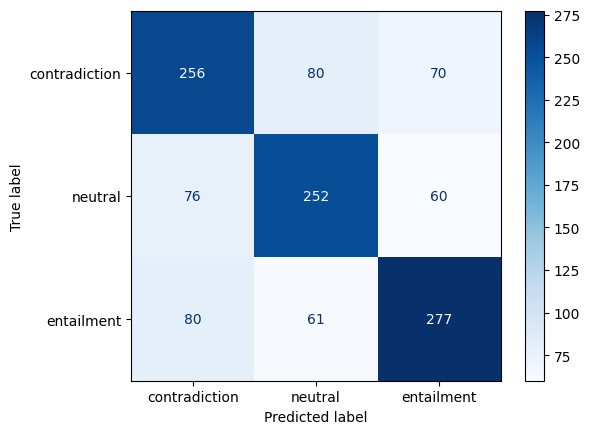

In [ ]:

!pip -q install -U transformers datasets evaluate scikit-learn matplotlib

import numpy as np
import torch
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from evaluate import load
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

#   Tokenisation (reuses train_df/val_df)
model_ckpt = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize_fn(batch):
    enc = tokenizer(
        batch["premise"], batch["hypothesis"],
        truncation=True, padding="max_length", max_length=256
    )
    enc["labels"] = batch["label"]
    return enc

drop_cols = ["id","premise","hypothesis","lang_abv","language","label"]
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))

tokenised = DatasetDict({
    "train": train_ds.map(tokenize_fn, batched=True, remove_columns=drop_cols),
    "val"  : val_ds.map(tokenize_fn,   batched=True, remove_columns=drop_cols)
}).with_format("torch")

#  Model init
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=3,
    id2label={0:"contradiction",1:"neutral",2:"entailment"},
    label2id={"contradiction":0,"neutral":1,"entailment":2}
)

#  TrainingArguments with EarlyStopping
args = TrainingArguments(
    output_dir="bert-multilang-watson",
    eval_strategy="epoch",    # or eval_strategy="epoch" on older TF versions
    save_strategy="epoch",
    save_total_limit=2,
    num_train_epochs=10,            # up to 10 epochs
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.10,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    seed=42,
    report_to="none",
)

# Metrics
accuracy = load("accuracy")
f1       = load("f1")
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=p.label_ids)["accuracy"],
        "macro_f1": f1.compute(predictions=preds, references=p.label_ids, average="macro")["f1"]
    }

#  Trainer with EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenised["train"],
    eval_dataset=tokenised["val"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("🚀 Fine‐tuning BERT (up to 10 epochs with early stop)…")
trainer.train()

#  Validation report
preds = trainer.predict(tokenised["val"]).predictions.argmax(-1)
print("\nValidation Classification Report:")
print(classification_report(val_df["label"], preds,
                            target_names=["contradiction","neutral","entailment"]))

ConfusionMatrixDisplay.from_predictions(
    val_df["label"], preds,
    display_labels=["contradiction","neutral","entailment"], cmap="Blues"
)
plt.show()


# **Fine-tuning morit/xlm-t-roberta-base-mnli-xnli on Watson**

tokenizer_config.json:   0%|          | 0.00/517 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Map:   0%|          | 0/10908 [00:00<?, ? examples/s]

Map:   0%|          | 0/1212 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

🚀 Fine-tuning XLM-RoBERTa-base-XNLI (3 epochs)…


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.731700,0.577920,0.798680,0.798366
2,0.471800,0.558031,0.801980,0.801635
3,0.390100,0.624273,0.796205,0.795807



Validation Classification Report:
               precision    recall  f1-score   support

contradiction       0.82      0.85      0.83       406
      neutral       0.74      0.79      0.77       388
   entailment       0.85      0.77      0.81       418

     accuracy                           0.80      1212
    macro avg       0.80      0.80      0.80      1212
 weighted avg       0.80      0.80      0.80      1212



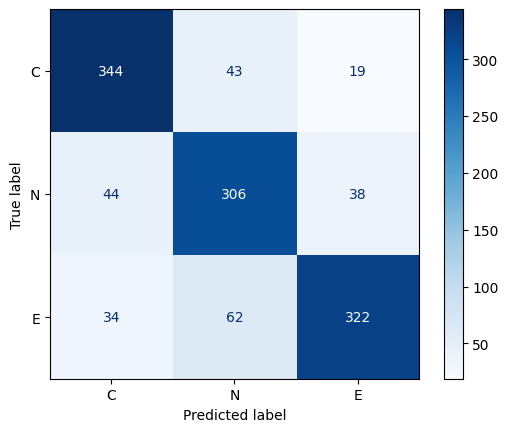

In [ ]:

!pip -q install -U transformers datasets evaluate scikit-learn matplotlib accelerate

import numpy as np
import torch
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from evaluate import load
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

#  Tokenisation (max_length=128)
tokenizer = AutoTokenizer.from_pretrained("morit/xlm-t-roberta-base-mnli-xnli")
def tokenize_fn(batch):
    enc = tokenizer(
        batch["premise"],
        batch["hypothesis"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    enc["labels"] = batch["label"]
    return enc

drop = ["id","premise","hypothesis","lang_abv","language","label"]
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))
data = DatasetDict({
    "train": train_ds.map(tokenize_fn, batched=True, remove_columns=drop),
    "val"  : val_ds.map(tokenize_fn,   batched=True, remove_columns=drop)
}).with_format("torch")

#  Load the MNLI+XNLI–finetuned model
model = AutoModelForSequenceClassification.from_pretrained(
    "morit/xlm-t-roberta-base-mnli-xnli",
    num_labels=3,
    id2label={0:"contradiction",1:"neutral",2:"entailment"},
    label2id={"contradiction":0,"neutral":1,"entailment":2}
)

#  TrainingArguments
args = TrainingArguments(
    output_dir="base-xnli-watson",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=5e-6,
    weight_decay=0.01,
    warmup_ratio=0.10,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    seed=42,
    report_to="none",
)

#  Metrics
acc = load("accuracy"); f1 = load("f1")
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=-1)
    return {
        "accuracy": acc.compute(predictions=preds, references=p.label_ids)["accuracy"],
        "macro_f1": f1.compute(predictions=preds, references=p.label_ids, average="macro")["f1"]
    }

#  Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=data["train"],
    eval_dataset=data["val"],
    compute_metrics=compute_metrics
)
print("🚀 Fine-tuning XLM-RoBERTa-base-XNLI (3 epochs)…")
trainer.train()

#  Validation report
val_preds = trainer.predict(data["val"]).predictions.argmax(-1)
print("\nValidation Classification Report:")
print(classification_report(val_df["label"], val_preds,
                            target_names=["contradiction","neutral","entailment"]))
ConfusionMatrixDisplay.from_predictions(
    val_df["label"], val_preds,
    display_labels=["C","N","E"], cmap="Blues"
)
plt.show()


# **Advanced Fine-Tuning of BERT-base-multilingual-cased for Multilingual NLI**

This script implements a two-phase fine-tuning pipeline on the Watson NLI dataset

Map:   0%|          | 0/10908 [00:00<?, ? examples/s]

Map:   0%|          | 0/1212 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Phase 1: head-only…


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.108500,1.097917,0.369637,0.328641
2,1.107000,1.094603,0.394389,0.352928
3,1.101000,1.094161,0.367987,0.288644


🚀 Phase 2: full-model…


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.003400,0.855809,0.603960,0.603714
2,0.741600,0.797917,0.664191,0.664442
3,0.579500,0.837593,0.675743,0.675304
4,0.435000,1.052255,0.665842,0.665602
5,0.365600,1.454064,0.669142,0.669169


               precision    recall  f1-score   support

contradiction       0.65      0.67      0.66       406
      neutral       0.67      0.65      0.66       388
   entailment       0.71      0.71      0.71       418

     accuracy                           0.68      1212
    macro avg       0.68      0.68      0.68      1212
 weighted avg       0.68      0.68      0.68      1212



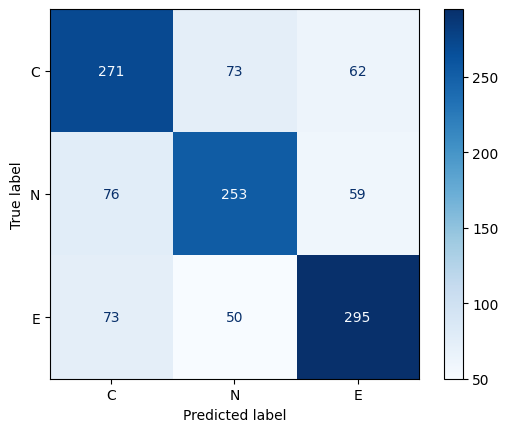

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.optim import AdamW
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    get_linear_schedule_with_warmup
)
from evaluate import load
from sklearn.metrics import classification_report, ConfusionMatrixDisplay



# Tokenisation
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
def tokenize_fn(batch):
    enc = tokenizer(batch["premise"], batch["hypothesis"],
                    truncation=True, padding="max_length", max_length=256)
    enc["labels"] = batch["label"]
    return enc

drop = ["id","premise","hypothesis","lang_abv","language","label"]
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))
data = DatasetDict({
    "train": train_ds.map(tokenize_fn, batched=True, remove_columns=drop),
    "val"  : val_ds.map(tokenize_fn,   batched=True, remove_columns=drop)
}).with_format("torch")

#  Multi-Sample Dropout head
class MultiSampleDropoutHead(nn.Module):
    def __init__(self, hidden_size, num_labels, drop_rate=0.5, n_samples=5):
        super().__init__()
        self.dropouts = nn.ModuleList([nn.Dropout(drop_rate) for _ in range(n_samples)])
        self.classifier = nn.Linear(hidden_size, num_labels)
    def forward(self, x):
        logits = [self.classifier(drop(x)) for drop in self.dropouts]
        return torch.mean(torch.stack(logits, dim=0), dim=0)

#   Model init + replace head
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=3,
    id2label={0:"contradiction",1:"neutral",2:"entailment"},
    label2id={"contradiction":0,"neutral":1,"entailment":2}
)
model.classifier = MultiSampleDropoutHead(model.config.hidden_size, model.config.num_labels)

#  Phase 1: head-only training
for param in model.bert.parameters(): param.requires_grad = False
optimizer1 = AdamW(model.classifier.parameters(), lr=5e-5, weight_decay=0.0)
steps1 = (len(data["train"]) // 16) * 3  # bs=16, epochs=3
scheduler1 = get_linear_schedule_with_warmup(optimizer1, int(0.1*steps1), steps1)
args1 = TrainingArguments("phase1", eval_strategy="epoch", save_strategy="epoch",
                         num_train_epochs=3, per_device_train_batch_size=16,
                         per_device_eval_batch_size=32, fp16=torch.cuda.is_available(),
                         load_best_model_at_end=True, metric_for_best_model="eval_accuracy",
                         report_to="none")
acc = load("accuracy"); f1 = load("f1")
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=-1)
    return {"accuracy": acc.compute(predictions=preds, references=p.label_ids)["accuracy"],
            "macro_f1": f1.compute(predictions=preds, references=p.label_ids, average="macro")["f1"]}
from transformers import EarlyStoppingCallback

trainer1 = Trainer(
    model=model,
    args=args1,
    train_dataset=data["train"],
    eval_dataset= data["val"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    optimizers=(optimizer1, scheduler1)
)
print("🚀 Phase 1: head-only…")
trainer1.train()

#  Phase 2: unfreeze & layer-wise LR
for param in model.parameters(): param.requires_grad = True
no_decay = ["bias","LayerNorm.weight"]; param_groups=[]
# head @5e-5
for n,p in model.classifier.named_parameters():
    param_groups.append({"params":p,"lr":5e-5,"weight_decay":0.0})
# encoder top4 @3e-5, next4 @2e-5, bottom4 @1e-5
layers = list(model.bert.encoder.layer)
for lr,grp in zip([3e-5,2e-5,1e-5],[layers[-4:],layers[4:8],layers[:4]]):
    for layer in grp:
        for n,p in layer.named_parameters():
            param_groups.append({
                "params":p, "lr":lr,
                "weight_decay":0.0 if any(nd in n for nd in no_decay) else 0.01
            })
optimizer2 = AdamW(param_groups)
steps2 = (len(data["train"]) // 8) * 5
scheduler2 = get_linear_schedule_with_warmup(optimizer2, int(0.1*steps2), steps2)
args2 = TrainingArguments("phase2", eval_strategy="epoch", save_strategy="epoch",
                         num_train_epochs=5, per_device_train_batch_size=8,
                         per_device_eval_batch_size=16, fp16=torch.cuda.is_available(),
                         load_best_model_at_end=True, metric_for_best_model="eval_accuracy",
                         report_to="none")
trainer2 = Trainer(
    model=model,
    args=args2,
    train_dataset=data["train"],
    eval_dataset= data["val"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    optimizers=(optimizer2, scheduler2)
)
print("🚀 Phase 2: full-model…")
trainer2.train()


#  Final eval
val_preds = trainer2.predict(data["val"]).predictions.argmax(-1)
print(classification_report(val_df["label"], val_preds,
      target_names=["contradiction","neutral","entailment"]))
ConfusionMatrixDisplay.from_predictions(val_df["label"], val_preds,
      display_labels=["C","N","E"], cmap="Blues")
plt.show()


# ** Advanced fine-tuning of RoBERTa-base (no custom head)**

           • Layer-wise LR decay
           • Early stopping

Map:   0%|          | 0/10908 [00:00<?, ? examples/s]

Map:   0%|          | 0/1212 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Training RoBERTa-base with layer-wise decay…


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.056700,0.927125,0.560231,0.554680
2,0.823500,0.858902,0.613036,0.614767
3,0.725100,0.846111,0.623762,0.624667
4,0.646700,0.927162,0.642739,0.637472
5,0.560300,0.982130,0.650990,0.650465


               precision    recall  f1-score   support

contradiction       0.58      0.71      0.64       406
      neutral       0.69      0.58      0.63       388
   entailment       0.71      0.66      0.68       418

     accuracy                           0.65      1212
    macro avg       0.66      0.65      0.65      1212
 weighted avg       0.66      0.65      0.65      1212



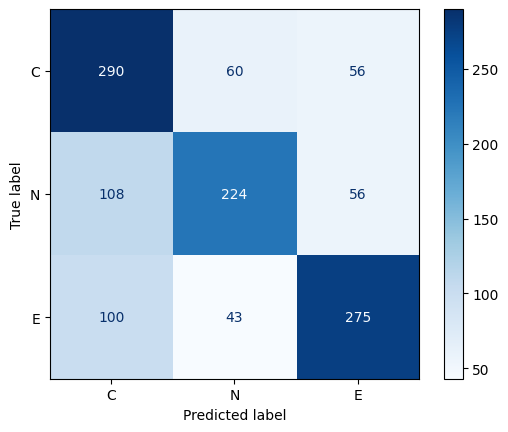

In [ ]:

import numpy as np
import torch
from torch.optim import AdamW
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    get_linear_schedule_with_warmup
)
from evaluate import load
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# 1️⃣ Tokenisation
MODEL_CKPT = "roberta-base"
tokenizer  = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize_fn(batch):
    enc = tokenizer(
        batch["premise"], batch["hypothesis"],
        truncation=True, padding="max_length", max_length=256
    )
    enc["labels"] = batch["label"]
    return enc

drop = ["id","premise","hypothesis","lang_abv","language","label"]
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))
data = DatasetDict({
    "train": train_ds.map(tokenize_fn, batched=True, remove_columns=drop),
    "val"  : val_ds.map(tokenize_fn,   batched=True, remove_columns=drop)
}).with_format("torch")

# 2️⃣ Model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=3,
    id2label={0:"contradiction",1:"neutral",2:"entailment"},
    label2id={"contradiction":0,"neutral":1,"entailment":2}
)

# 3️⃣ Layer-wise LR decay
no_decay = ["bias","LayerNorm.weight"]
param_groups = []

# head @ 5e-5
for n,p in model.classifier.named_parameters():
    param_groups.append({
        "params": p,
        "lr": 5e-5,
        "weight_decay": 0.0 if any(nd in n for nd in no_decay) else 0.01
    })

# encoder: top4 @3e-5, mid4 @2e-5, bottom4 @1e-5
layers = list(model.roberta.encoder.layer)
for lr, grp in zip([3e-5,2e-5,1e-5],[layers[-4:],layers[4:8],layers[:4]]):
    for layer in grp:
        for n,p in layer.named_parameters():
            param_groups.append({
                "params": p,
                "lr": lr,
                "weight_decay": 0.0 if any(nd in n for nd in no_decay) else 0.01
            })

optimizer = AdamW(param_groups)
steps = (len(data["train"]) // 8) * 5  # 5 epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * steps),
    num_training_steps=steps
)

# 4️⃣ TrainingArguments + EarlyStopping
args = TrainingArguments(
    output_dir="roberta-adv-simple",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    warmup_ratio=0.10,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    seed=42,
    report_to="none",
)

acc = load("accuracy"); f1 = load("f1")
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=-1)
    return {
      "accuracy": acc.compute(predictions=preds, references=p.label_ids)["accuracy"],
      "macro_f1": f1.compute(predictions=preds, references=p.label_ids, average="macro")["f1"]
    }

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=data["train"],
    eval_dataset=data["val"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    optimizers=(optimizer, scheduler)
)

print("🚀 Training RoBERTa-base with layer-wise decay…")
trainer.train()

# 5️⃣ Evaluation
preds = trainer.predict(data["val"]).predictions.argmax(-1)
print(classification_report(
    val_df["label"], preds,
    target_names=["contradiction","neutral","entailment"]
))
ConfusionMatrixDisplay.from_predictions(
    val_df["label"], preds,
    display_labels=["C","N","E"], cmap="Blues"
)
plt.show()



# **Fine-tuning joeddav/xlm-roberta-large-xnli**


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/tokenization_auto.py:898: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Map:   0%|          | 0/10908 [00:00<?, ? examples/s]

Map:   0%|          | 0/1212 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


🚀 Fine-tuning large-XNLI with OOM fixes…


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
0,0.258800,0.269319,0.916667,0.916414
1,0.218600,0.281865,0.924917,0.924700
2,0.296400,0.470898,0.904290,0.904304


               precision    recall  f1-score   support

contradiction       0.92      0.94      0.93       406
      neutral       0.91      0.92      0.91       388
   entailment       0.95      0.92      0.93       418

     accuracy                           0.92      1212
    macro avg       0.92      0.92      0.92      1212
 weighted avg       0.93      0.92      0.92      1212



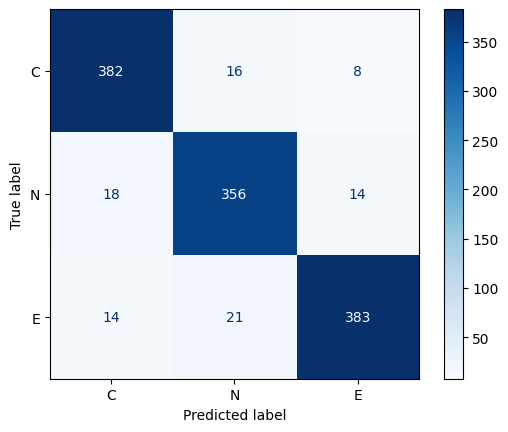

In [ ]:
import numpy as np
import torch
from torch.optim import AdamW
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    get_linear_schedule_with_warmup
)
from evaluate import load
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#  Tokenisation – shorter max_length to save memory
tokenizer = AutoTokenizer.from_pretrained(
    "joeddav/xlm-roberta-large-xnli", use_auth_token=True
)
def tokenize_fn(batch):
    enc = tokenizer(
        batch["premise"], batch["hypothesis"],
        truncation=True,
        padding="max_length",
        max_length=192,
    )
    enc["labels"] = batch["label"]
    return enc

drop = ["id","premise","hypothesis","lang_abv","language","label"]
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))
data = DatasetDict({
    "train": train_ds.map(tokenize_fn, batched=True, remove_columns=drop),
    "val"  : val_ds.map(tokenize_fn, batched=True, remove_columns=drop),
}).with_format("torch")

# Model init + gradient checkpointing + partial freeze
model = AutoModelForSequenceClassification.from_pretrained(
    "joeddav/xlm-roberta-large-xnli",
    use_auth_token=True,
    num_labels=3,
    id2label={0:"contradiction",1:"neutral",2:"entailment"},
    label2id={"contradiction":0,"neutral":1,"entailment":2}
)
model.gradient_checkpointing_enable()

# Freeze the bottom half of the encoder layers
for layer in model.roberta.encoder.layer[:12]:
    for param in layer.parameters():
        param.requires_grad = False

# Optimizer & scheduler with layer-wise decay
no_decay = ["bias","LayerNorm.weight"]
param_groups = []

# head @5e-5
for n,p in model.classifier.named_parameters():
    param_groups.append({
        "params":p, "lr":5e-5,
        "weight_decay":0.0 if any(nd in n for nd in no_decay) else 0.01
    })

# remaining top 12 layers split into three groups @3e-5,2e-5,1e-5
top_layers = list(model.roberta.encoder.layer[12:])
for lr, grp in zip([3e-5,2e-5,1e-5], np.array_split(top_layers, 3)):
    for layer in grp:
        for n,p in layer.named_parameters():
            param_groups.append({
                "params":p, "lr":lr,
                "weight_decay":0.0 if any(nd in n for nd in no_decay) else 0.01
            })

optimizer = AdamW(param_groups)

total_steps = (len(data["train"]) // 1) * 3  # bs=1, epochs=3
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# TrainingArguments – tiny batch + accumulation + fp16
args = TrainingArguments(
    output_dir="advanced-finetune-xnli",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    num_train_epochs=3,
    per_device_train_batch_size=2,       # 1 example at a time
    gradient_accumulation_steps=8,       # accumulate to effective bs=8
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    warmup_ratio=0.10,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    report_to="none",
    seed=42
)

#  Metrics & Trainer
acc = load("accuracy"); f1 = load("f1")
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=-1)
    return {
        "accuracy": acc.compute(predictions=preds, references=p.label_ids)["accuracy"],
        "macro_f1": f1.compute(predictions=preds, references=p.label_ids, average="macro")["f1"]
    }

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=data["train"],
    eval_dataset=data["val"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
    optimizers=(optimizer, scheduler)
)

print("🚀 Fine-tuning large-XNLI with OOM fixes…")
trainer.train()

# Final evaluation
preds = trainer.predict(data["val"]).predictions.argmax(-1)
print(classification_report(val_df["label"], preds,
                            target_names=["contradiction","neutral","entailment"]))
ConfusionMatrixDisplay.from_predictions(
    val_df["label"], preds, display_labels=["C","N","E"], cmap="Blues"
)
plt.show()


# **GPT-4 Few-Shot NLI Evaluation on a Subset of the Validation**

This script samples a smaller subset (75 examples) from the full validation DataFrame (`val_df`) and runs a GPT-4 few-shot prompt to classify each example into one of three NLI labels: 0 = contradiction, 1 = neutral, 2 = entailment.



In [ ]:
import pandas as pd
from tqdm.auto import tqdm
from openai.error import RateLimitError
import time

 Sample a smaller validation set (e.g. 200 examples)
val_small = val_df.sample(n=75, random_state=42).reset_index(drop=True)

#plugging val_small into your GPT-4 few-shot loop:


few_shot = [
    {"role":"system","content":
     "You are an NLI model. Answer with one digit: 0=contradiction, 1=neutral, 2=entailment."},
    {"role":"user","content":"Premise: She did not reply.\nHypothesis: She was silent.\nLabel:"},
    {"role":"assistant","content":"2"},
    {"role":"user","content":"Premise: He forgot to study.\nHypothesis: He performed well.\nLabel:"},
    {"role":"assistant","content":"0"},
    {"role":"user","content":"Premise: They hear the music.\nHypothesis: They are listening.\nLabel:"},
    {"role":"assistant","content":"1"},
]

val_preds = []
for prem, hyp in tqdm(zip(val_small.premise, val_small.hypothesis), total=len(val_small)):
    messages = few_shot + [
        {"role":"user","content":f"Premise: {prem}\nHypothesis: {hyp}\nLabel:"}
    ]
    while True:
        try:
            resp = openai.ChatCompletion.create(
                model="gpt-4",
                messages=messages,
                temperature=0,
                max_tokens=1
            )
            val_preds.append(int(resp.choices[0].message.content.strip()))
            break
        except RateLimitError:
            time.sleep(0.5)  # back off and retry

# Compute metrics on val_small
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

y_true = val_small["label"].to_numpy()
acc   = accuracy_score(y_true, val_preds)
f1m   = f1_score(y_true, val_preds, average="macro")
print(f"Acc: {acc:.3f}, Macro-F1: {f1m:.3f}")


  0%|          | 0/75 [00:00<?, ?it/s]

Acc: 0.867, Macro-F1: 0.864



# **GPT-2 Fine‑Tuning for Watson NLI**  


Train: (10908, 6), Val: (1212, 6), Test: (5195, 5)


Map:   0%|          | 0/10908 [00:00<?, ? examples/s]

Map:   0%|          | 0/1212 [00:00<?, ? examples/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Fine-tuning GPT-2 on Watson NLI…


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.948900,0.990097,0.502475,0.468887
2,0.874900,0.863789,0.572607,0.567369
3,0.733500,0.879496,0.588284,0.583077
4,0.661700,0.978031,0.599835,0.596617
5,0.508300,1.080620,0.594884,0.592023



Validation Report:
               precision    recall  f1-score   support

contradiction       0.63      0.70      0.66       418
      neutral       0.64      0.50      0.56       388
   entailment       0.54      0.59      0.57       406

     accuracy                           0.60      1212
    macro avg       0.60      0.60      0.60      1212
 weighted avg       0.60      0.60      0.60      1212



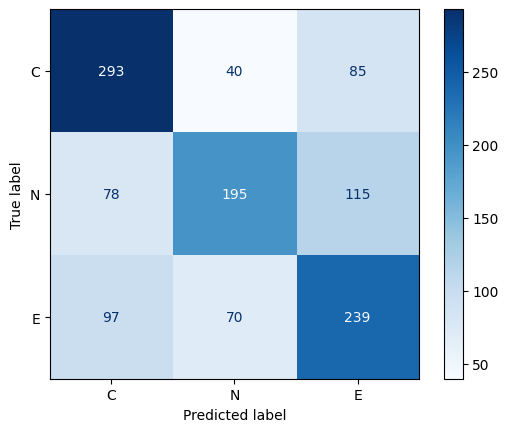

Map:   0%|          | 0/5195 [00:00<?, ? examples/s]

✅ Saved watson_submission_gpt2.csv


In [ ]:


#  Install dependencies
!pip install -q transformers datasets evaluate scikit-learn matplotlib

#  Imports
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    GPT2ForSequenceClassification,
    TrainingArguments,
    Trainer
)
from evaluate import load
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#  Load & split data
df = pd.read_csv("train.csv").dropna(subset=["premise","hypothesis","label"])
df["label"] = df["label"].astype(int)
train_df, val_df = train_test_split(df, test_size=0.10,
                                     stratify=df["label"], random_state=42)
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
test_df  = pd.read_csv("test.csv")

print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")

#  Tokenizer setup
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # use EOS token as PAD

def tokenize_fn(batch):
    enc = tokenizer(
        batch["premise"],
        batch["hypothesis"],
        padding="max_length",
        truncation=True,
        max_length=192
    )
    enc["labels"] = batch["label"]
    return enc

# Build HF datasets
drop_cols = ["id","premise","hypothesis","lang_abv","language","label"]
train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)
data = DatasetDict({
    "train": train_ds.map(tokenize_fn, batched=True, remove_columns=drop_cols),
    "val"  : val_ds.map(tokenize_fn,   batched=True, remove_columns=drop_cols)
}).with_format("torch")

#  Model init
model = GPT2ForSequenceClassification.from_pretrained(
    "gpt2",
    num_labels=3
)
model.config.pad_token_id = model.config.eos_token_id  # ensure pad token id set

#  Training arguments
args = TrainingArguments(
    output_dir="gpt2-watson-nli",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    num_train_epochs=5,
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    warmup_ratio=0.1,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    logging_steps=50,
    seed=42,
    report_to="none"
)

#  Metrics function
accuracy = load("accuracy")
f1       = load("f1")
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=p.label_ids)["accuracy"],
        "macro_f1": f1.compute(predictions=preds, references=p.label_ids, average="macro")["f1"]
    }

#  Trainer & training
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=data["train"],
    eval_dataset=data["val"],
    compute_metrics=compute_metrics
)
print("🚀 Fine-tuning GPT-2 on Watson NLI…")
trainer.train()

# Evaluate on validation
val_pred = trainer.predict(data["val"]).predictions.argmax(axis=-1)
print("\nValidation Report:")
print(classification_report(val_df["label"], val_pred,
                            target_names=["contradiction","neutral","entailment"]))
ConfusionMatrixDisplay.from_predictions(
    val_df["label"], val_pred,
    display_labels=["C","N","E"], cmap="Blues"
)
plt.show()

# Predicting on test.csv & save submission


#   Building a HF Dataset from your test DataFrame
test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))

#  Tokenize (drop *only* the columns that actually exist)
test_drop_cols = ["id","premise","hypothesis","lang_abv","language"]
tokenized_test = test_ds.map(
    lambda batch: tokenizer(
        batch["premise"],
        batch["hypothesis"],
        padding="max_length",
        truncation=True,
        max_length=128
    ),
    batched=True,
    remove_columns=test_drop_cols
).with_format("torch")

#  Run inference
test_preds = trainer.predict(tokenized_test).predictions.argmax(axis=-1)

#  Save CSV
submission = pd.DataFrame({
    "id": test_df["id"],
    "label": test_preds
})
submission.to_csv("watson_submission_gpt2.csv", index=False)
print("✅ Saved watson_submission_gpt2.csv")

